Fitting a baseline ARIMA model to our data as well as benchmarking with various statistics.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

We need to load in the original data 

In [4]:
crack_spread_df = pd.read_csv(r'../data/processed/crack_spread.csv')
crack_spread_df.drop(['close_crude', 'close_gasoil', 'Unnamed: 0'], axis=1, inplace=True)
crack_spread_df.set_index('date', inplace=True)
crack_spread_df


,crack_spread
date,
2009-05-08,6.471260
2009-05-11,7.064236
2009-05-12,6.838820
2009-05-13,6.725845
2009-05-14,4.781314
...,...
2025-09-02,25.162949
2025-09-03,27.205630
2025-09-04,26.676220


Now we need to split the data in order to evaluate our model later. We will use an 80-20 split of training/testing

In [5]:
split_row = int(len(crack_spread_df) * 0.8)
train_data = crack_spread_df[:split_row]
test_data = crack_spread_df[split_row:]

Now with our split data, we will use a SARIMAX model. The reason for SARIMAX despite using ARIMA is such that we can add seasonal parameters if we so wish as well as exogenous factors

In [6]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

arima_model = SARIMAX(train_data, order=(1,1,1), seasonal_order=(0,0,0,0))
fitted_model = arima_model.fit(disp=False)
fitted_model.summary()

/Users/anurag/Documents/repos/gasoil-crack-spread-analysis/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/anurag/Documents/repos/gasoil-crack-spread-analysis/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           crack_spread   No. Observations:                 3341
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -5531.512
Date:                Sat, 13 Sep 2025   AIC                          11069.025
Time:                        22:38:06   BIC                          11087.366
Sample:                             0   HQIC                         11075.586
                               - 3341                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6162      0.015     41.596      0.000       0.587       0.645
ma.L1         -0.8078      0.010    -79.142      0.000      -0.828      -0.788
sigma2         1.6070      0.011    149.414      0.000       1.586       1.628
===================================================================================
Ljung-Box (L1) (Q):                   3.87   Jarque-Bera (JB):            117095.86
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               2.18   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Now we'll use our fitted model and predict our test data.

In [7]:
start = len(train_data)
end = len(train_data) + len(test_data) -1

predictions = fitted_model.predict(start=start, end=end)

/Users/anurag/Documents/repos/gasoil-crack-spread-analysis/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/anurag/Documents/repos/gasoil-crack-spread-analysis/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


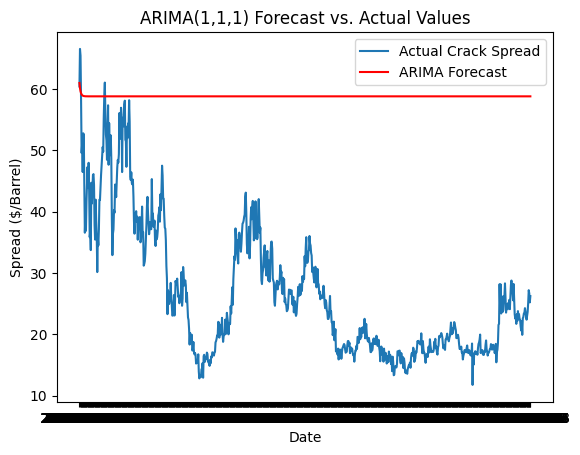

In [8]:
plt.plot(test_data.index, test_data, label='Actual Crack Spread')
plt.plot(test_data.index, predictions, label='ARIMA Forecast', color='red')
plt.title('ARIMA(1,1,1) Forecast vs. Actual Values')
plt.xlabel('Date')
plt.ylabel('Spread ($/Barrel)')
plt.legend()
plt.show()

As can be seen above, this is a terrible forecast. Now this may be because we ignored seasonality despite its presence in the original data. Let's put it back into the model and observe. We will add a differencing of 1 and we add seasonality by trading year which follows from the 

/Users/anurag/Documents/repos/gasoil-crack-spread-analysis/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/anurag/Documents/repos/gasoil-crack-spread-analysis/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/anurag/Documents/repos/gasoil-crack-spread-analysis/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/anurag/Documents/repos/gasoil-crack-spread-analysis/.venv/lib/python3.12/site-packages/statsmodel

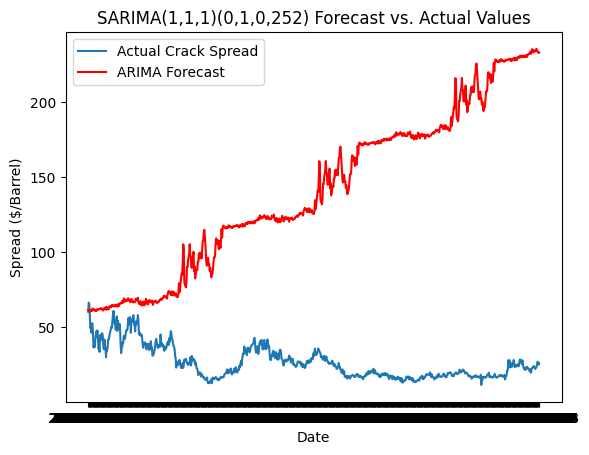

In [9]:
sarima_model = SARIMAX(train_data, order=(1,1,1), seasonal_order=(0,1,0,252))
sarima_fitted_model = sarima_model.fit(disp=False)
sarima_predictions = sarima_fitted_model.predict(start=start, end=end)
plt.plot(test_data.index, test_data, label='Actual Crack Spread')
plt.plot(test_data.index, sarima_predictions, label='ARIMA Forecast', color='red')
plt.title('SARIMA(1,1,1)(0,1,0,252) Forecast vs. Actual Values')
plt.xlabel('Date')
plt.ylabel('Spread ($/Barrel)')
plt.legend()
plt.show()

Now performing evaluations and calculating metrics. First we should perform a naïve forecast to provide a bare minimum. Then ideally our model performs better.

In [10]:
naive_pred = test_data.shift(1).dropna()

shifted_test_data = test_data[1:]

naive_rmse = np.sqrt(mean_squared_error(shifted_test_data, naive_pred))
naive_mae = mean_absolute_error(shifted_test_data, naive_pred)

print(f"\nNaive Forecast RMSE: {naive_rmse:.4f}")
print(f"Naive Forecast MAE: {naive_mae:.4f}")


Naive Forecast RMSE: 2.1851
Naive Forecast MAE: 1.4808


Now time for our model

In [11]:
sarima_rmse = np.sqrt(mean_squared_error(test_data, sarima_predictions))
sarima_mae = mean_absolute_error(test_data, sarima_predictions)

print(f"Your SARIMA Model RMSE: {sarima_rmse:.4f}")
print(f"Your SARIMA Model MAE: {sarima_mae:.4f}")

Your SARIMA Model RMSE: 129.8703
Your SARIMA Model MAE: 114.3201


**Now unfortunately, our SARIMA model performed significantly worse than the naive predictions implying (both statistically and visually) that our model is not great at predicting crack spread prices. There could be several reasons for this as detailed below.**

1)  SARIMA assumes fairly stationary relationships within the data. Time series financial data is famously non-stationary. In addition, there have been a lot of regime changes within the data. In particular, our model is trained on data before 2020 which was fairly stable. However, post-2020 a lot of changes occurred such as Covid, war and instability. The model has not been trained on this data and as such is unable to properly adapt to the new data.

2)  Based on how much the spread changed as a result of wars etc., our model is likely not to perform well. We are excluding exogenous data, data which affects the spread critically as we saw in our EDA. Thus it being a univariate model led to not so good of a performance.

**Having said that, it is good we explored the failed assumptions of this model to inform our next steps. Here is what I would do to improve our forecasting:**

1)  **Exogenous Data:** First we need to incorporate external and calculated data into our model. This would include:
    * Inventory Levels
    * Crude Oil Supply data
    * Geopolitical events
    * Weather data
    * Moving averages

2)  **Try Machine Learning Models:** Since the data has so many complex patterns and sudden changes, it's a perfect candidate for machine learning. These models are much better at learning the non-linear relationships between lots of different inputs.

    * We could use models like **XGBoost** or a **Linear Regression** model. For these, we'd create a range of features from our time series (like the moving averages and lags you mentioned) and combine them with the exogenous data.
    * An even better approach might be an **LSTM (Long Short-Term Memory)** network. LSTMs are a type of neural network built specifically for time series data and are great at learning long-term patterns, which could help the model understand the different market conditions we've seen over the years.

    A really interesting idea, backed by recent research, is to try a **hybrid approach** [cite: [https://www.abacademies.org/articles/crack-spread-forecasting-for-supply-chain-optimization-a-hybrid-model-using-time-series-and-deep-learning-with-bayesian-optimizati-16510.html](https://www.abacademies.org/articles/crack-spread-forecasting-for-supply-chain-optimization-a-hybrid-model-using-time-series-and-deep-learning-with-bayesian-optimizati-16510.html)]. We could let an ARIMA model capture the basic, linear parts of the series, and then train an LSTM model on the errors (residuals) to predict the complex patterns that ARIMA missed. The final prediction would then be the ARIMA forecast plus the LSTM's error forecast, giving us the best of both worlds.